# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(Time.discrete, Source.majority, Past.last_bin, Durl.all)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Prepare these arrays for stopword-checking.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            lemmas = substitution.source.lemmas[dslice]
            tokens = substitution.source.tokens[dslice]
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token) in enumerate(zip(words, lemmas, tokens)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': substitution.tags[0],
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 9071 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all)


100% (9071 of 9071) |######################| Elapsed Time: 0:01:49 Time: 0:01:49


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

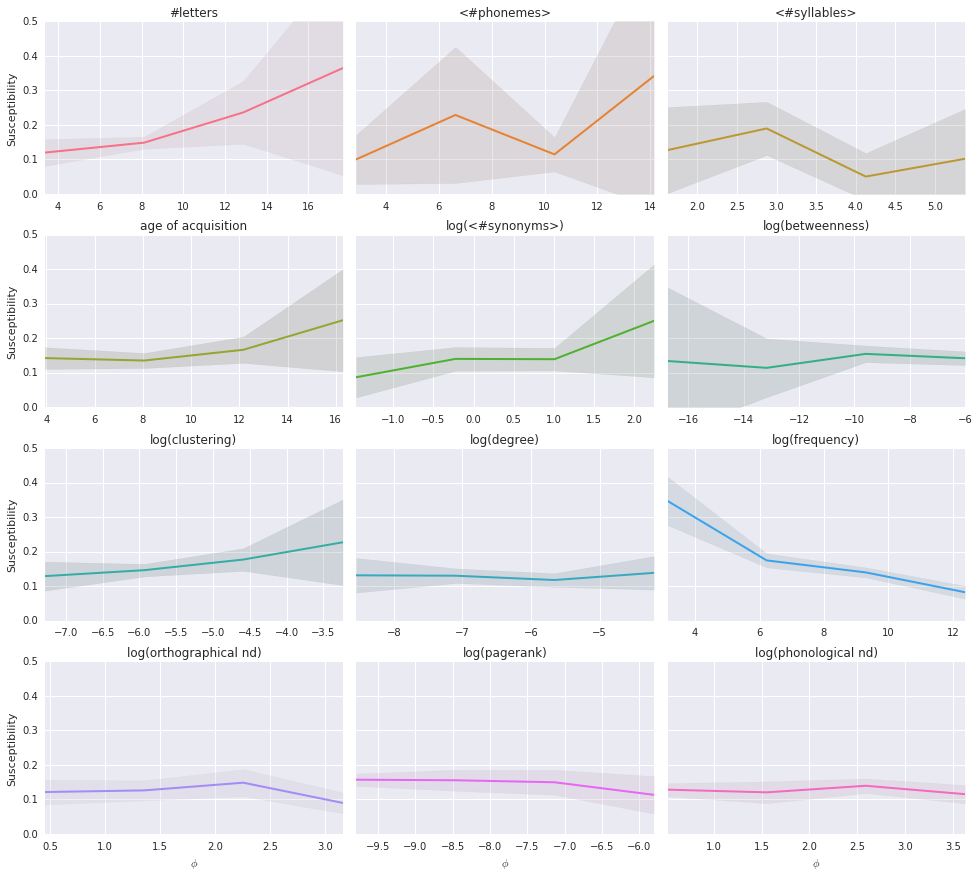

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

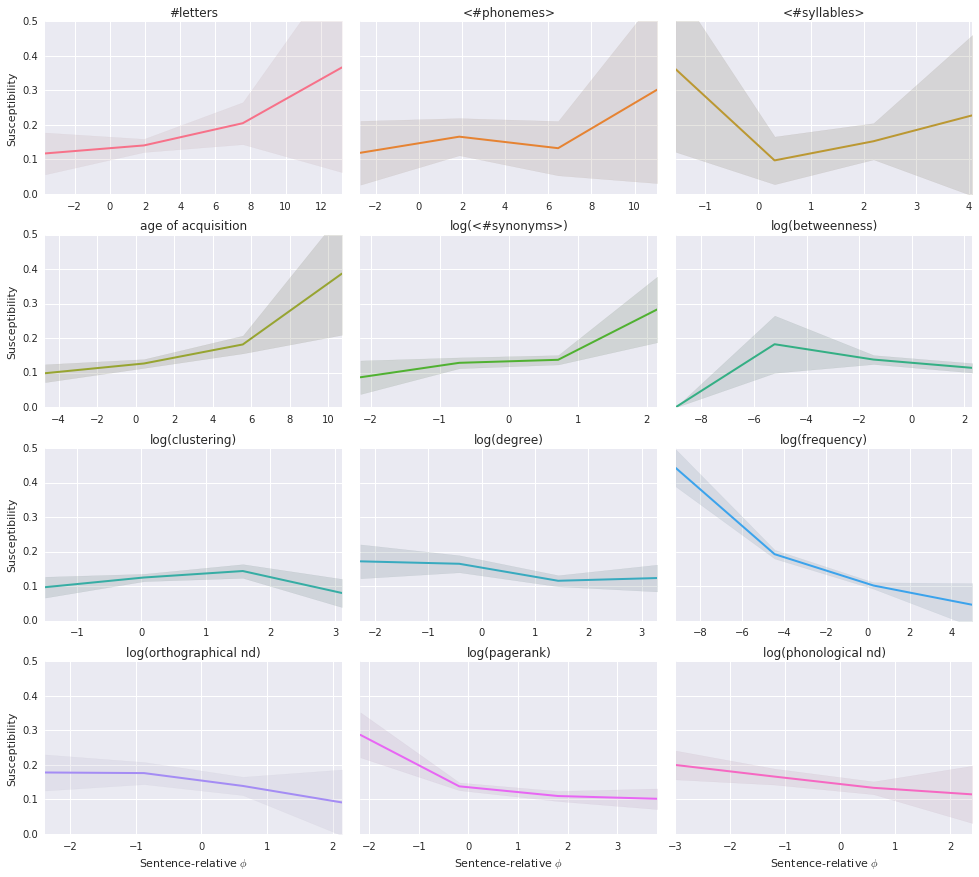

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

## 3 On which POS tags do substitutions fall?

In [9]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'word']]
poses['rPOS'] = poses['POS'].apply(lambda x: x[0])

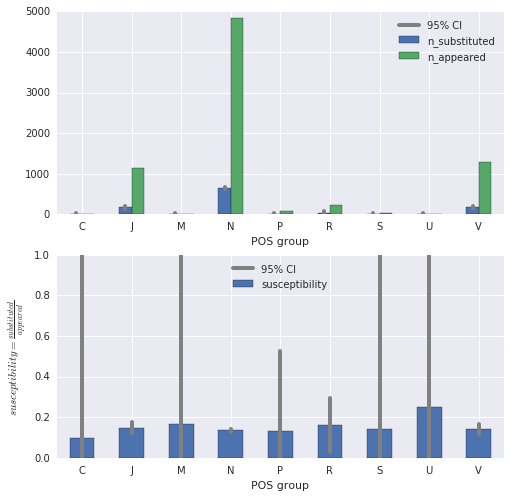

In [10]:
# Compute POS counts.
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted, method='sison_glaz')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 1), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

## 4 Susceptibility in terms of absolute fractiles

In [11]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights, method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

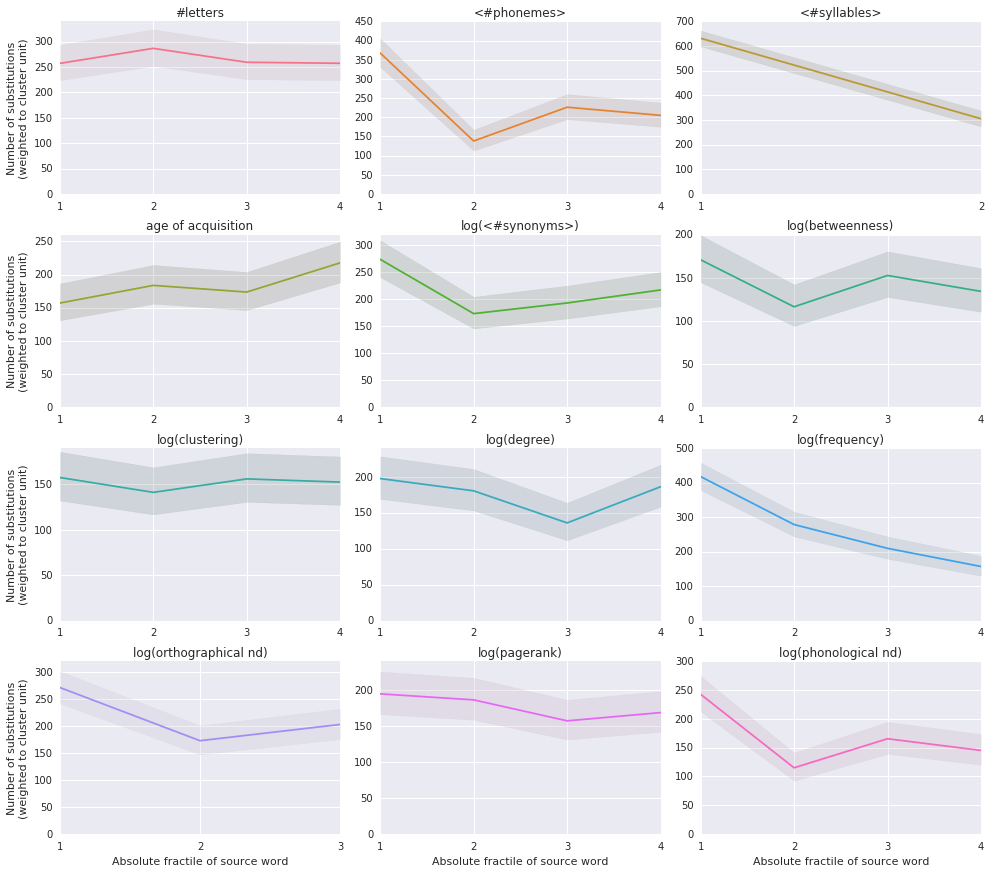

In [12]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [13]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

100% (9071 of 9071) |######################| Elapsed Time: 0:01:50 Time: 0:01:50


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [14]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [15]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights, method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

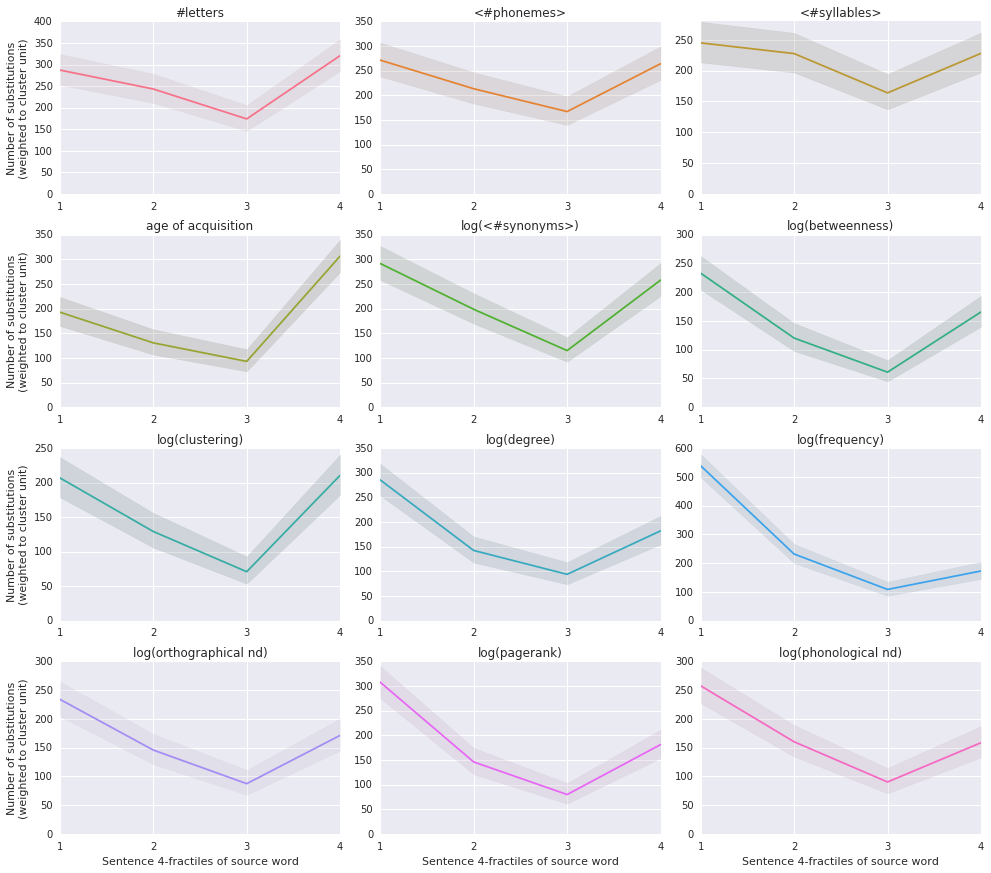

In [16]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.